### Don't Rerun below (it's slow 46mins)

In [62]:
from ipynb.fs.full.yt_web import get_video_data

In [13]:
from ipynb.fs.full.sentiment_small import flairPredict as predict_small

In [14]:
# from ipynb.fs.full.sentiment_large import flairPredict as predict_large

In [34]:
import collections

In [15]:
score_to_text = {0:'BAD', 1:'GOOD'}
videos = get_video_data()

In [67]:
tags = [1, 2, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
id_to_tag =  {1:'Film & Animation',2:'Autos & Vehicles',10:'Music',15:'Pets & Animals',17:'Sports',18:'Short Movies',19:'Travel & Events',20:'Gaming',21:'Videoblogging',22:'People & Blogs',23:'Comedy',24:'Entertainment',25:'News & Politics',26:'Howto & Style',27:'Education',28:'Science & Technology',29:'Nonprofits & Activism',30:'Movies',31:'Anime/Animation',32:'Action/Adventure',33:'Classics',34:'Comedy',35:'Documentary',36:'Drama',37:'Family',38:'Foreign',39:'Horror',40:'Sci-Fi/Fantasy',41:'Thriller',42:'Shorts',43:'Shows',44:'Trailers'}

In [17]:
sentence = "I love the way you explained, plus the diversity :)"
max_len = 30
sentence_pred = predict_small(sentence)
result = f'{score_to_text[sentence_pred]}: {sentence[:max_len]}...'
print(result)

sentence = "I hate the way you explained, plus no diversity"
sentence_pred = predict_small(sentence)
result = f'{score_to_text[sentence_pred]}: {sentence[:max_len]}...'
print(result)

GOOD: I love the way you explained, ...
BAD: I hate the way you explained, ...


In [31]:
for v in videos.values():
    print(id_to_tag[v.category_id])

Entertainment
Film & Animation
Entertainment
Sports
Music
Music
Sports
Entertainment
Music
Music


### Types of charts
#### tag -> sentiment ratio Sports [40% positive]  -- compare most positive tags
#### Word blob | comments / tag (all, pos, neg)
#### each tag, have most popular topics top 5: [soccer: fifa 60% pos , messi 80% pos] [music: bts]
#### comments/view_count / tag  = how enganging is a tag 
#### word generator


In [55]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
  
example_sent = """This is a sample sentence,
                  showing off the stop words filtration."""
  
stop_words = set(stopwords.words('english'))
  

In [76]:
tags_counder = {}
for v in videos.values():
    for s in v.comments:
        for w in s.split():
            if w.lower() not in stop_words:
                if int(v.category_id) not in tags_counder:
                    tags_counder[int(v.category_id)] = [w]
                else: tags_counder[int(v.category_id)].append(w)
for t in tags:
    if t in tags_counder:
        print(id_to_tag[t] , ' - ', collections.Counter(tags_counder[t]).most_common(10))

Film & Animation  -  [('Indiana', 4), ('Jones', 4), ('wasn’t', 2), ('time', 2), ('retiring', 2), ('end', 2), ('series', 2), ('Seeing', 1), ('Sallah', 1), ('smile', 1)]
Music  -  [('Namjoon', 6), ('song', 5), ('like', 4), ('love', 3), ('te', 3), ('Kim', 3), ('arte', 2), ('amo', 2), ('I’m', 2), ('pretty', 2)]
Sports  -  [('Japan', 4), ('goal', 4), ('lost', 3), ('second', 3), ('last', 2), ('Congrats', 2), ('South', 2), ('happy', 2), ('go', 2), ('Portugal', 2)]
Entertainment  -  [('love', 4), ('going', 3), ('really', 3), ('thought', 3), ('rez', 3), ('guardians', 2), ('hold', 2), ("I'm", 2), ('feel', 2), ('Drax', 2)]


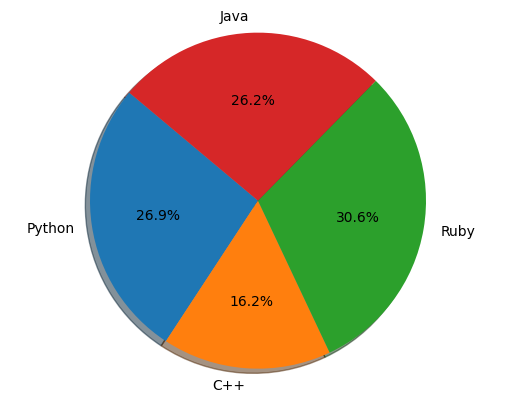

In [77]:
import matplotlib.pyplot as plt
labels = ['Python', 'C++', 'Ruby', 'Java']
sizes = [215, 130, 245, 210]
# Plot
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()